# Week 4: Tasks

1. Find helpers for visualization and loading data in `helpers.py`. Please make sure to go through them so you understand their purpose. Feel free to tweak these or add your ones.

2. First approach the theoretical tasks to make sure you can understand and frame the problems correctly.

3. Solve the programming tasks making use of the helpers.

---

## Theoretical Tasks: framing convex programs

Write up your solutions (brief explanations) in markdown.



**Problem 0: Were you listening?**

For each of the following optimization problems:
1. State whether it is a **convex optimization problem** or **not**.
2. Justify your answer briefly (one sentence is enough).

#### (a)
$$
\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & x^\top Q x + c^\top x \\
\text{s.t.} \quad & Ax = b
\end{aligned}
$$

where $Q \succeq 0$, $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^m$.

#### (b)
$$
\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & \|x\|_2^2 \\
\text{s.t.} \quad & \|Ax\|_2 \ge 1
\end{aligned}
$$
where $A \in \mathbb{R}^{m \times n}$.

#### (c)
$$
\begin{aligned}
\max_{w \in \mathbb{R}^n} \quad & (\mu^\top w)(\mathbf{1}^\top w) \\
\text{s.t.} \quad & w \ge 0
\end{aligned}
$$

where $\mu \in \mathbb{R}^n$ is fixed.

---

**Problem 1: Minimum-norm Feasibility**
  
You are given a system of linear equations $Cx=d$, where $C\in\mathbb{R}^{k\times n}$ has full row rank and $d\in\mathbb{R}^k$.  
Among all vectors $x$ that satisfy the constraints, you wish to select one that is in some sense “small”.

1. Formulate this task as a **convex optimization problem**.
2. Argue why the problem is feasible and has a unique solution.
3. *(Bonus)* Derive a closed-form expression for the optimal solution.

*Hints*  
- What properties must the objective function satisfy? Try reasoning about it to come up with a metric that preserves these properties and is convex.
- Lagrange multipliers and first-order optimality conditions are sufficient to solve the problem explicitly (part 3).

---


**(BONUS) Problem 2: Stochastic Robust Approximation**

Consider a linear approximation problem in which the data matrix is uncertain. Let
$$
A=\bar A+U,
$$
where $U$ is a random matrix with $\mathbb{E}[U]=0$. The goal is to choose $x$ that performs well *on average* under this uncertainty.

1. **Stochastic robust objective.**  
   Consider the problem
   $$
   \min_x \; \mathbb{E}\,\|Ax-b\|.
   $$
   - Show that this is a convex optimization problem.  
   - If $A$ takes finitely many values $\{A_i\}_{i=1}^k$ with probabilities $p_i$, rewrite the objective explicitly and express the problem as a deterministic convex program.  
   - Comment briefly on when this formulation can be written as an LP or an SOCP, depending on the choice of norm. ([This](https://zhengy09.github.io/ECE285/lectures/L6.pdf) might help).

2. **Quadratic specialization.**  
   Now consider the least-squares variant
   $$
   \min_x \; \mathbb{E}\,\|Ax-b\|_2^2.
   $$
   - Show that the objective can be written as the sum of a nominal least-squares term and an additional quadratic term involving $x$.  
   - *(Bonus $^2$)* Use this structure to derive a closed-form solution.

3. **Discussion.**  
   - How does uncertainty in $A$ influence the geometry and conditioning of the solution?

---

> Type in your answers here. You may write it in plaintext or paste pictures, but math formatting is preferred.

Problem 0

a convex optimisation problem since it is a quadratic program with a positive and semi-definite Q, which guarantees convexity.

b not a convex optimisation problem since the set is non-convex or the volume other than that of a ball.

c not a convex optimisation problem since it turns into a quadratic program with the matrix $Q = u \, 1^\top$ which is not symmetric.

Problem 1

1 $$\min_{x} \; \|x\|_2^2 \quad \text{subject to} \quad Cx = d$$

2 The solution is feasible since the set of the solutions of $Cx=d$ is non-empty(C has full row rank). The problem has a unique solution since the problem is a quadratic program with positive definite $Q$ matrix.

3 $$\min_{x} \; \|x\|_2^2 \quad \text{subject to} \quad Cx = d$$
$$ \mathcal{L}(x,\nu)=x^\top x + \nu^\top(d-Cx)$$
$$ \nabla_x \mathcal{L}(x^*,\nu^*)=0 \quad \Longrightarrow \quad 2x^* - C^\top\nu^* = 0$$
$$ x^* = \frac{1}{2} C^\top\nu^*$$
Putting in $Cx=d$, we get
$$ \nu^* = 2(CC^\top)^{-1}d$$
$$ x^* = C^\top(CC^\top)^{-1}d $$
is the unique solution.

...


---

## Task 0: Store week 2/3 data and read it in
Use helpers to store your expected returns and risk data along with tickers, and read them to load them into this notebook.

See usage in `intro_to_cvxpy.ipynb` in the fully solved example.

NOTE: The week 2 models only predict expected returns ($\hat\mu$), we compute $\hat\Sigma$ as simple covariance matrix of the tickers' returns data for now. In reality predicting $\hat\Sigma$ is a big challenge (perhaps bigger than predicting $\hat\mu$) but we overlook those concerns for now.

For eg: `Sigma_hat = np.cov(returns, rowvar=False)`, where `returns` contains the returns data series for the tickers we are studying.

In [35]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
)

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf

# -----------------------
# Parameters
# -----------------------
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "NVDA"]
long_start = "2015-01-01"
long_end   = "2024-01-01"

# -----------------------
# Download data
# -----------------------
print("Downloading long-term data...")
long_data = yf.download(
    tickers,
    start=long_start,
    end=long_end,
    progress=False,
    group_by="ticker"
)

# -----------------------
# Helper: extract Adj Close and Volume
# -----------------------
def extract_adj_close_and_volume(yf_df, tickers):
    adj_dict = {}
    vol_dict = {}

    for t in tickers:
        df = yf_df[t]

        # Adjusted Close handling
        if "Adj Close" in df.columns:
            adj_dict[t] = df["Adj Close"]
        elif "Close" in df.columns:
            adj_dict[t] = df["Close"]
        else:
            raise KeyError(f"No Adjusted Close or Close for {t}")

        # Volume
        if "Volume" in df.columns:
            vol_dict[t] = df["Volume"]
        else:
            raise KeyError(f"No Volume column for {t}")

    adj = pd.DataFrame(adj_dict)
    vol = pd.DataFrame(vol_dict)
    return adj, vol

# -----------------------
# Extract clean data
# -----------------------
long_adj, long_vol = extract_adj_close_and_volume(long_data, tickers)

# -----------------------
# Compute returns
# -----------------------
returns = long_adj.pct_change().dropna()

# -----------------------
# Compute mu and Sigma
# -----------------------
mu = returns.mean().values          # shape (6,)
Sigma = returns.cov().values        # shape (6, 6)

# Optional annualization
mu = 252 * mu
Sigma = 252 * Sigma

# -----------------------
# Save to predicted.npz
# -----------------------
np.savez_compressed(
    "predicted.npz",
    mu_hat=mu,
    Sigma_hat=Sigma,
    tickers=np.array(tickers)
)

# -----------------------
# Sanity check
# -----------------------
data = np.load("predicted.npz", allow_pickle=True)

print("Saved fields:", data.files)
print("mu_hat shape:", data["mu_hat"].shape)
print("Sigma_hat shape:", data["Sigma_hat"].shape)
print("tickers:", data["tickers"])

Saved fields: ['mu_hat', 'Sigma_hat', 'tickers']
mu_hat shape: (6,)
Sigma_hat shape: (6, 6)
tickers: ['AAPL' 'MSFT' 'GOOG' 'AMZN' 'TSLA' 'NVDA']


/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_62003/1583485421.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  long_data = yf.download(


In [37]:
# TODO: assuming u saved your data in `predicted.npz`

# mu, Sigma, tickers = load_predictions('predicted.npz')

Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA']

Mean returns (mu):
[0.27199367 0.2870633  0.22830757 0.30986005 0.47451338 0.63070575]

Covariance matrix (Sigma):
[[0.08432367 0.0562377  0.05167803 0.05497227 0.0703969  0.07938563]
 [0.0562377  0.07742809 0.05778808 0.06080065 0.06470323 0.08284702]
 [0.05167803 0.05778808 0.08175415 0.06252307 0.06075978 0.0756664 ]
 [0.05497227 0.06080065 0.06252307 0.11066997 0.07443247 0.08273124]
 [0.0703969  0.06470323 0.06075978 0.07443247 0.3183962  0.11549373]
 [0.07938563 0.08284702 0.0756664  0.08273124 0.11549373 0.23189664]]

Shapes:
mu shape: (6,)
Sigma shape: (6, 6)


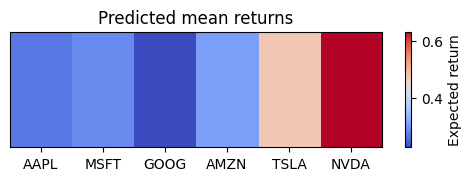

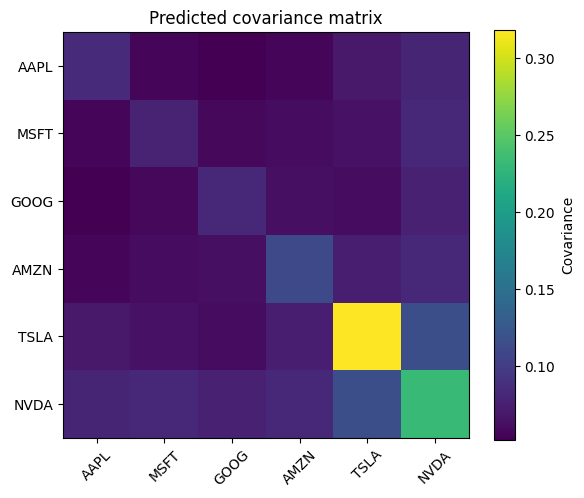

In [38]:
# TODO: plot the data using helpers (and maybe print some lines) to confirm
mu, Sigma, tickers = load_predictions("predicted.npz")

print("Tickers:", tickers)
print("\nMean returns (mu):")
print(mu)

print("\nCovariance matrix (Sigma):")
print(Sigma)

print("\nShapes:")
print("mu shape:", mu.shape)
print("Sigma shape:", Sigma.shape)

plot_mu_and_cov(mu, Sigma, tickers)

## Task 1. Baseline portfolios

### Task 1.1 Equal weight portfolio

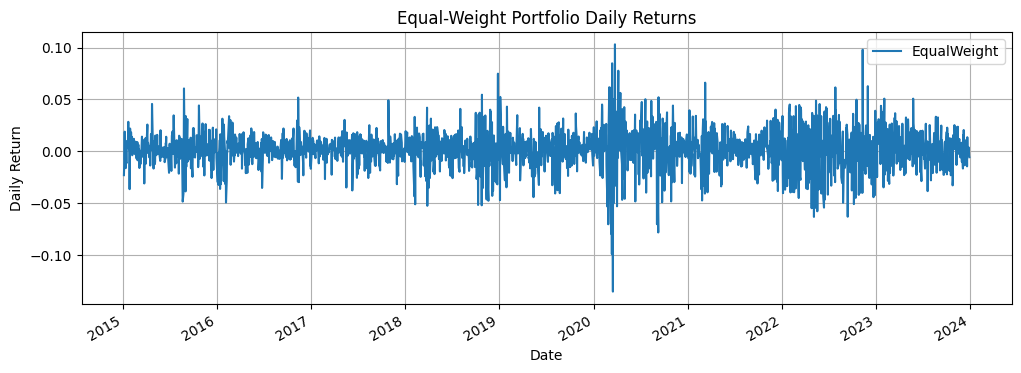

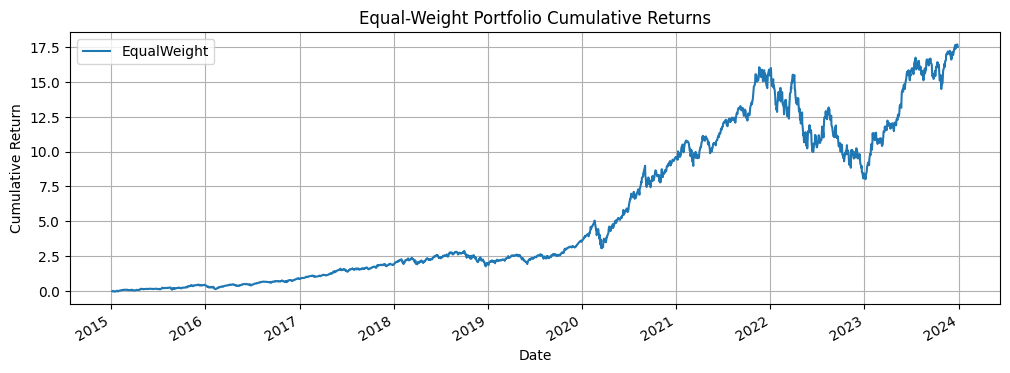

In [39]:
# TODO: define `w_equal` to be the portfolio with equal weights on all assets
n = len(tickers)
w_equal = np.ones(n) / n

# Portfolio daily returns
portfolio_returns = returns @ w_equal  # matrix multiplication

# Convert to a DataFrame for convenience
portfolio_returns = pd.DataFrame(portfolio_returns, index=returns.index, columns=["EqualWeight"])
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Daily returns
portfolio_returns.plot(figsize=(12, 4))
plt.title("Equal-Weight Portfolio Daily Returns")
plt.ylabel("Daily Return")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# Cumulative returns
cumulative_returns.plot(figsize=(12, 4))
plt.title("Equal-Weight Portfolio Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Task 1.2 Global Minimum Variance Portfolio, without long-only constraint
Formally, define the problem of **minimizing $\mathbf{w}^\top \Sigma \mathbf{w}$ subject to $\mathbf{1}^\top \mathbf{w} = 1$**. This gives the minimum variance portfolio, a reasonable baseline for evaluation, see Sec 6.5.1 of the book for a formal definition.

(without the long-only constraint) The solution can be written analytically as:
$$
\mathbf{w} = \frac{1}{\mathbf{1}^\top \Sigma^{-1} \mathbf{1}} \Sigma^{-1}\mathbf{1}
$$

Compute this using numpy. This our second baseline.

GMV portfolio weights: [ 0.34331811  0.35821783  0.31673361  0.09674405  0.00539229 -0.1204059 ]
Sum of weights: 1.0


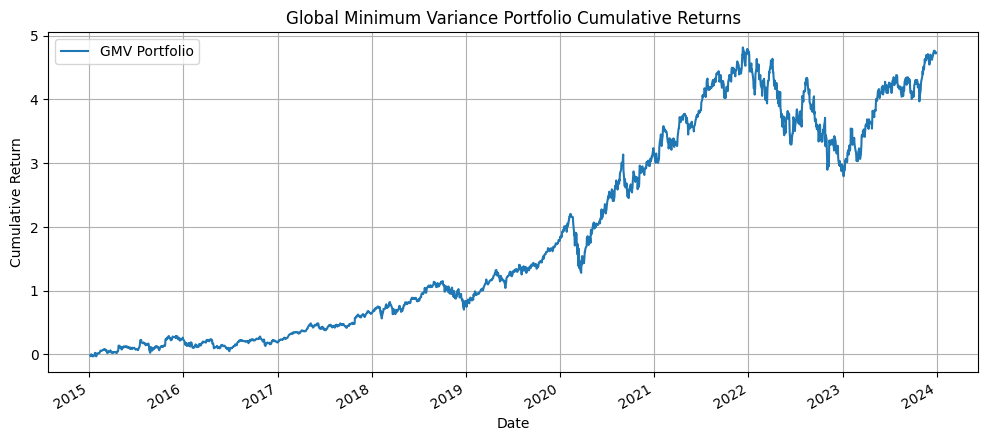

In [40]:
# TODO: define `w_minvar` according to above. use `np.linalg.inv` to take inverse.

# Number of assets
n = len(tickers)

# Compute Σ^-1
Sigma_inv = np.linalg.inv(Sigma)

# Vector of ones
ones = np.ones(n)

# Global Minimum Variance portfolio weights
w_gmv = Sigma_inv @ ones / (ones @ Sigma_inv @ ones)

# Sanity check
print("GMV portfolio weights:", w_gmv)
print("Sum of weights:", w_gmv.sum())

# Portfolio daily returns
gmv_returns = returns @ w_gmv
gmv_cum_returns = (1 + gmv_returns).cumprod() - 1

gmv_cum_returns.plot(figsize=(12,5), label="GMV Portfolio")
plt.title("Global Minimum Variance Portfolio Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()

---

## Task 2. Markowitz Optimization - Additional constraints

We add two additional constraints:
1. Leverage limit - leverage defines the "total" asset positions as L1 norm $|| w ||_1$.
2. Maximum position limit - limit the maximum weight that can be placed on one asset to force diversification. For simplicity we use a scalar $u$ and enforce $|w_i| \le u; \forall i=1\dots n$

> Fruther on these definitions: A [paper](https://web.stanford.edu/~boyd/papers/pdf/markowitz.pdf) by Stephen Boyd, see pages 13-15.

### Task 2.1: Write a helper function in similar spirit to the one in the intro notebook.

Formally it should implement the following convex program:

$$
\begin{align*}
\max_w \quad & \mu^\top w - \lambda w^\top \Sigma w \\
\text{s.t.}\quad & \mathbf{1}^\top w = 1 & \text{(fully invested)} \\
& w \ge \mathbf{0} & \text{(long only)} \\
& ||w||_1 \le \gamma & \text{(leverage limit)} \\
\forall i \quad & |w_i| \le u  & \text{(max position limit)} \\
\end{align*}
$$

The helper should take lambda, gamma and u as inputs along with mu and Sigma.

In [41]:
# TODO

def markowitz_portfolio(mu, Sigma, lam, gamma=2, u=1):
    pass # implement
    """
    Compute Markowitz portfolio with additional constraints:
      - fully invested: 1^T w = 1
      - long-only: w >= 0
      - leverage limit: ||w||_1 <= gamma
      - maximum position limit: w_i <= u

    Parameters
    ----------
    mu : array-like, shape (n,)
        Expected returns
    Sigma : array-like, shape (n, n)
        Covariance matrix
    lam : float
        Risk aversion parameter
    gamma : float
        Leverage limit (default 2)
    u : float
        Maximum position limit per asset (default 1)

    Returns
    -------
    w_opt : np.array, shape (n,)
        Optimized portfolio weights
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    n = len(mu)

    # Define optimization variable
    w = cp.Variable(n)

    # Objective: maximize mu^T w - lambda w^T Sigma w
    # Equivalent to: minimize lambda w^T Sigma w - mu^T w
    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))

    # Constraints
    constraints = [
        cp.sum(w) == 1,          # fully invested
        w >= 0,                  # long-only
        cp.norm1(w) <= gamma,    # leverage limit
        w <= u                   # max position limit
    ]

    # Solve QP
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)  # SCS or OSQP works well for QPs

    if w.value is None:
        raise ValueError("Optimization failed")

    w_opt = w.value
    return w_opt


### Task 2.2 Vary different parameters and study the portfolios obtained

As a baseline use $\lambda = 1.2; \; \gamma = 1.6 \; u = 0.8$. You may tweak this if you like.

Try any subset of these; the goal is to analyze performance and possibly interpret the results to identify the best set of parameters.

1. Vary $\lambda$ over $0.01, 0.1, 1.0, 3.5, 10.0$
2. Vary $\gamma$ over $1.4, 1.6, 1.8$
3. Vary $u$ over $0.6, 0.8, 0.95$

Then, Collect your results as `weights, returns, variances` : 2D numpy arrays as an example:
```python
# demo
lams = np.logspace(-2, 2, 15)

weights = []
returns = []
variances = []

for lam in lams:
    w = markowitz_portfolio(mu_hat, Sigma_hat, lam)
    weights.append(w)
    returns.append(mu_hat @ w)
    variances.append(w.T @ Sigma_hat @ w)

weights = np.array(weights)
returns = np.array(returns)
variances = np.array(variances)
```

> If you're really comfortable with python you might be able to abstract this away in a wrapped functions or use decorators to prevent rewriting this same template every time. But that's not necessary.


In [42]:
# TODO: run for loop(s) to test out these hyperparameter tunings
# if you would like to do a full exploration of the state space there is a python library that allows you to take cross product of sets
import numpy as np
import itertools

# -----------------------------
# Hyperparameter ranges
# -----------------------------
lams = [0.01, 0.1, 1.0, 3.5, 10.0]       # risk aversion
gammas = [1.4, 1.6, 1.8]                 # leverage limits
us = [0.6, 0.8, 0.95]                    # max position per asset

# -----------------------------
# Containers for results
# -----------------------------
weights_list = []
returns_list = []
variances_list = []
labels = []

# -----------------------------
# Sweep over all combinations
# -----------------------------
for lam, gamma, u in itertools.product(lams, gammas, us):
    try:
        w = markowitz_portfolio(mu, Sigma, lam, gamma=gamma, u=u)
    except ValueError:
        print(f"Optimization failed for lam={lam}, gamma={gamma}, u={u}")
        continue

    weights_list.append(w)
    returns_list.append(mu @ w)
    variances_list.append(w.T @ Sigma @ w)
    labels.append(f"λ={lam}, γ={gamma}, u={u}")

# -----------------------------
# Convert to arrays
# -----------------------------
weights = np.array(weights_list)    # shape (n_portfolios, n_assets)
returns = np.array(returns_list)   # shape (n_portfolios,)
variances = np.array(variances_list) # shape (n_portfolios,)

print("Swept", len(weights), "portfolios")
print("Shape of weights array:", weights.shape)


Swept 45 portfolios
Shape of weights array: (45, 6)


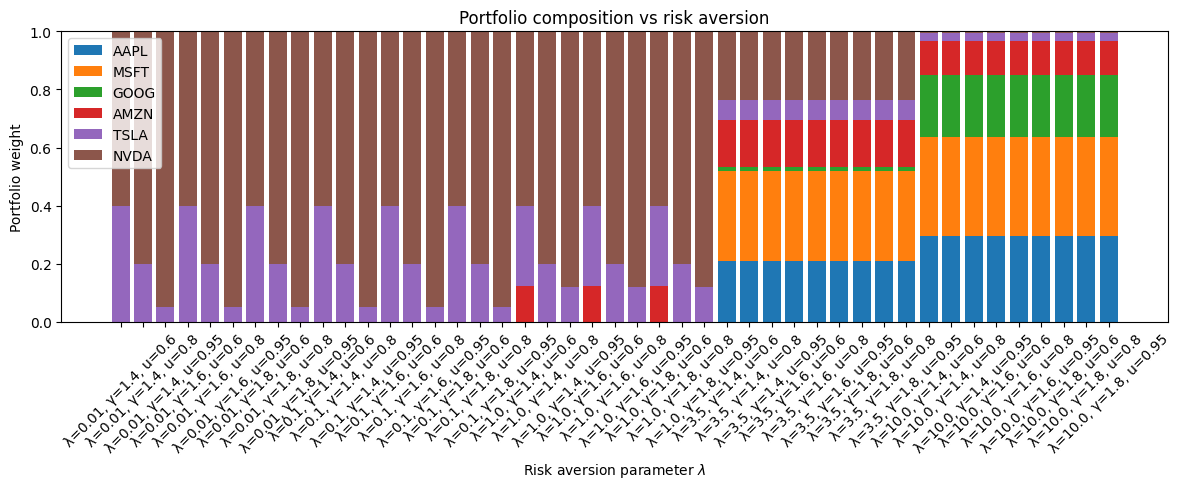

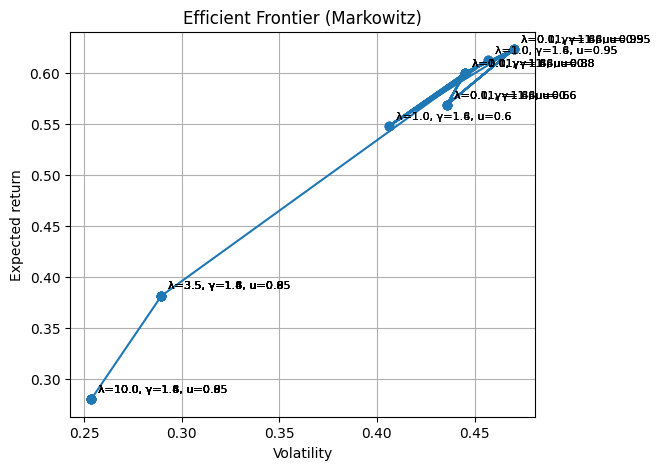

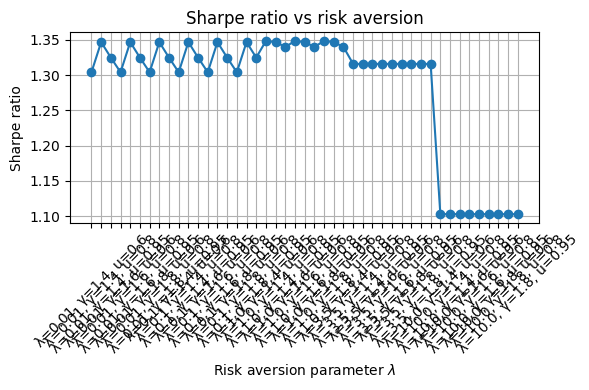

         λ |     Return |   Volatility |     Sharpe
----------------------------------------------------
λ=0.01, γ=1.4, u=0.6 |     0.5682 |       0.4357 |     1.3041
λ=0.01, γ=1.4, u=0.8 |     0.5995 |       0.4451 |     1.3468
λ=0.01, γ=1.4, u=0.95 |     0.6229 |       0.4702 |     1.3248
λ=0.01, γ=1.6, u=0.6 |     0.5682 |       0.4357 |     1.3041
λ=0.01, γ=1.6, u=0.8 |     0.5995 |       0.4451 |     1.3468
λ=0.01, γ=1.6, u=0.95 |     0.6229 |       0.4702 |     1.3248
λ=0.01, γ=1.8, u=0.6 |     0.5682 |       0.4357 |     1.3041
λ=0.01, γ=1.8, u=0.8 |     0.5995 |       0.4451 |     1.3468
λ=0.01, γ=1.8, u=0.95 |     0.6229 |       0.4702 |     1.3248
λ=0.1, γ=1.4, u=0.6 |     0.5682 |       0.4357 |     1.3041
λ=0.1, γ=1.4, u=0.8 |     0.5995 |       0.4451 |     1.3468
λ=0.1, γ=1.4, u=0.95 |     0.6229 |       0.4702 |     1.3248
λ=0.1, γ=1.6, u=0.6 |     0.5682 |       0.4357 |     1.3041
λ=0.1, γ=1.6, u=0.8 |     0.5995 |       0.4451 |     1.3468
λ=0.1, γ=1.6, u=0.95 |     0

In [43]:
# TODO: visualize the portfolios using the helpers or use your own
# weights: shape (n_portfolios, n_assets)
# labels: list of strings with hyperparameter combinations
visualize_weights_stacked(weights, labels=labels, tickers=tickers)
visualize_return_risk(returns, variances, labels, use_volatility=True)
sharpe, _, _ = compute_sharpe_ratios(weights, mu, Sigma)
plot_sharpe_ratios(sharpe, labels=labels)
print_sharpe_table(labels, sharpe, returns, variances)

---
## Task 3. Robust (adversarial) optimization

We now model uncertainty in predicted returns.

#### Uncertainty model

We assume the true return vector lies in an $\ell_2$-ball around the predicted value:
$$
\mu = \hat\mu + \delta,
\qquad
\|\delta\|_2 \le \epsilon.
$$

> Note this is NOT the same as the $\ell_\infty$-ball error described in the README. Convince yourself that they do not correspond to the same minimization problem.

The robust optimization problem is
$$
\begin{aligned}
\max_w \min_{\|\delta\|_2 \le \epsilon}
\;& (\hat\mu + \delta)^\top w - \lambda\, w^\top \Sigma w \\
\text{s.t. } & \mathbf{1}^\top w = 1,\quad w \ge 0.
\end{aligned}
$$

Interestingly, this reduces to the convex program
$$
\begin{aligned}
\max_w \;& \hat\mu^\top w - \epsilon \|w\|_2 - \lambda\, w^\top \Sigma w \\
\text{s.t. } & \mathbf{1}^\top w = 1,\quad w \ge 0.
\end{aligned}
$$

This allows us to easily implement it in cvxpy.

---

### Task 3.1 - Implement the robust Markowitz solver
Write a helper similar to task 2.1

In [44]:
# TODO: 
def robust_markowitz(mu, Sigma, lam, eps):
    pass
    """
    Robust Markowitz portfolio under ℓ2 uncertainty in returns.

    Solves:
        max_w  mu^T w - eps * ||w||_2 - lam * w^T Sigma w
        s.t.   1^T w = 1
               w >= 0

    Parameters
    ----------
    mu : array-like, shape (n,)
        Predicted mean returns (μ̂)
    Sigma : array-like, shape (n, n)
        Covariance matrix
    lam : float
        Risk aversion parameter
    eps : float
        Robustness radius (ℓ2-ball size)

    Returns
    -------
    w_opt : np.ndarray, shape (n,)
        Optimal robust portfolio weights
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    n = len(mu)

    # Optimization variable
    w = cp.Variable(n)

    # Objective
    objective = cp.Maximize(
        mu @ w
        - eps * cp.norm(w, 2)
        - lam * cp.quad_form(w, Sigma)
    )

    # Constraints
    constraints = [
        cp.sum(w) == 1,   # fully invested
        w >= 0            # long-only
    ]

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    if w.value is None:
        raise ValueError("Robust Markowitz optimization failed")

    return w.value


### Perturbation analysis

The robust formulation provides a worst-case guarantee.
We can analyze it with an empirical sensitivity experiment.

The goal is to sample perturbations $\delta$ uniformly from the $\ell_2$ ball of radius $\epsilon$ and evaluate portfolio performance under these perturbed returns.

> This is similar to the kind of analysis done using Monte Carlo methods

### Task 4.2 - Empirical robustness via perturbation analysis

For perturbing the returns vector use this helper `sample_l2_perturbations` to generate a 2D array of perturbed vectors - our samples.

> Specifically, we generate a random direction $u/||u||_2$ where $u \sim \mathcal{N}(0, I)$ and random length $d \sim \text{Uniform}(0,\epsilon)$


In [48]:
import numpy as np

def sample_l2_perturbations(n, eps, num_samples, seed=None):
    """
    Sample perturbations uniformly from the l2 ball of radius eps.

    Parameters
    ----------
    n : int
        Dimension of the vector
    eps : float
        Radius of the l2 ball
    num_samples : int
        Number of perturbation vectors to generate
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    deltas : np.ndarray, shape (num_samples, n)
        Random perturbation vectors
    radii : np.ndarray, shape (num_samples,)
        Random radii used for each sample
    """
    if seed is not None:
        np.random.seed(seed)

    deltas = []
    radii = []
    for _ in range(num_samples):
        u = np.random.randn(n)
        u = u / np.linalg.norm(u)        # random direction
        r = np.random.uniform(0, eps)    # random radius
        deltas.append(r * u)
        radii.append(r)

    return np.array(deltas), np.array(radii)

Nominal return: 0.27972421533342284
Mean perturbed return: 0.2794006731132939
Worst-case perturbed return: 0.259968726054459
5th percentile: 0.26932014120066455


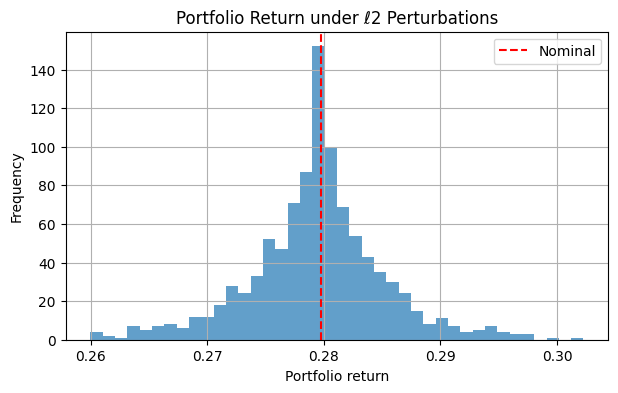

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Uncertainty radius
# ============================
eps = 0.05          # ← ADD THIS
num_samples = 1000

# ============================
# Generate perturbations
# ============================
deltas, radii = sample_l2_perturbations(
    n=len(mu),
    eps=eps,
    num_samples=num_samples,
    seed=42
)

# ============================
# Evaluate portfolio
# ============================
mu_perturbed = mu + deltas              # (num_samples, n)
portfolio_returns = mu_perturbed @ w    # (num_samples,)

# ============================
# Print statistics
# ============================
print("Nominal return:", mu @ w)
print("Mean perturbed return:", portfolio_returns.mean())
print("Worst-case perturbed return:", portfolio_returns.min())
print("5th percentile:", np.percentile(portfolio_returns, 5))

# ============================
# Plot distribution
# ============================
plt.figure(figsize=(7,4))
plt.hist(portfolio_returns, bins=40, alpha=0.7)
plt.axvline(mu @ w, color="red", linestyle="--", label="Nominal")
plt.xlabel("Portfolio return")
plt.ylabel("Frequency")
plt.title("Portfolio Return under ℓ2 Perturbations")
plt.legend()
plt.grid(True)
plt.show()


Set $\lambda = 1.2, \epsilon = 0.1$, use $\text{num\_sample}=100$ and generate the portfolios and deltas.

In [50]:
# TODO: first run the markowitz_portfolio and robust_markowitz functions to get portfolios
# remember robust_markowitz takes an additional eps parameter
lam = 1.2
eps = 0.1
num_samples = 100

# solve portfolios
#...
w_markowitz = markowitz_portfolio(mu, Sigma, lam)
w_robust = robust_markowitz(mu, Sigma, lam, eps)

print("Markowitz portfolio weights:")
print(w_markowitz)
print("\nRobust Markowitz portfolio weights:")
print(w_robust)

# ============================
# Sample perturbations
# ============================
deltas, _ = sample_l2_perturbations(
    len(mu),
    eps,
    num_samples
)


# sample perturbations
# NOTE: use
#deltas, _ = sample_l2_perturbations(len(mu), eps, num_samples)

Markowitz portfolio weights:
[-6.53172507e-07 -2.04541739e-06 -4.75968905e-07 -1.06552727e-06
  1.60733787e-01  8.39270456e-01]

Robust Markowitz portfolio weights:
[3.39144647e-03 5.82435551e-02 2.91241157e-07 1.10186514e-01
 1.90534403e-01 6.37643760e-01]


Evaluate the portfolios under the list of perturbed means and collect results in 1D arrays `ret_std` and `ret_rob` (for eg).

Nominal return: 0.27972421533342284
Mean perturbed return: 0.2794006731132939
Worst-case perturbed return: 0.259968726054459
5th percentile: 0.26932014120066455


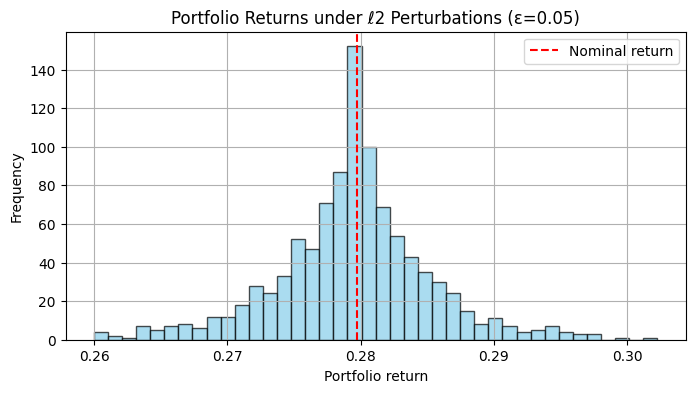

In [51]:
# TODO: evaluate the portfolios under perturbations and collect results
# remember to use `mu_perturbed = mu + delta` for each delta in deltas
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
eps = 0.05          # radius of uncertainty
num_samples = 1000  # number of perturbation samples

# -------------------------------
# Sample perturbations
# -------------------------------
deltas, _ = sample_l2_perturbations(len(mu), eps, num_samples, seed=42)

# -------------------------------
# Evaluate portfolio under perturbations
# -------------------------------
# mu_perturbed: shape (num_samples, n)
mu_perturbed = mu + deltas

# Portfolio returns for each sample: shape (num_samples,)
portfolio_returns = mu_perturbed @ w

# -------------------------------
# Summary statistics
# -------------------------------
print("Nominal return:", mu @ w)
print("Mean perturbed return:", portfolio_returns.mean())
print("Worst-case perturbed return:", portfolio_returns.min())
print("5th percentile:", np.percentile(portfolio_returns, 5))

# -------------------------------
# Plot histogram of perturbed returns
# -------------------------------
plt.figure(figsize=(8,4))
plt.hist(portfolio_returns, bins=40, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(mu @ w, color="red", linestyle="--", label="Nominal return")
plt.xlabel("Portfolio return")
plt.ylabel("Frequency")
plt.title(f"Portfolio Returns under ℓ2 Perturbations (ε={eps})")
plt.legend()
plt.grid(True)
plt.show()


Visualize your results and answer these questions:
- Plot histograms of the data points (realized portfolio returns) in both arrays and analyze visually. What do you observe?
- Print out summary statistics
    - Mean, Median, Worst (minimum return)

In [ ]:
# TODO: visualize results

### Task 4.3 (Bonus) But how poorly does standard optimization do?
This analysis does not really show "how" the standard portfolio performance degrades as delta grows larger. For that we can make a scatter plot of the form
$$(||\delta||, \text{realized returns on } \hat\mu+\delta)$$
For both portfolios. Try doing this and analyzing the result. Helper code is given.

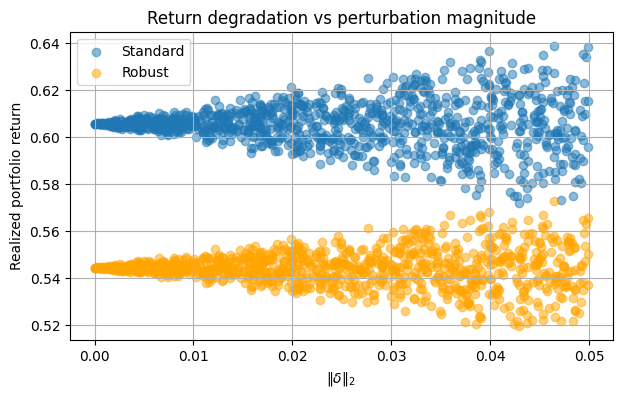

In [53]:
# -------------------------------
# Compute portfolio returns under each perturbation
# -------------------------------
ret_std = (mu + deltas) @ w_markowitz      # standard Markowitz portfolio
ret_rob = (mu + deltas) @ w_robust        # robust Markowitz portfolio

# -------------------------------
# Scatter plot: realized return vs perturbation magnitude
# -------------------------------
plt.figure(figsize=(7, 4))
plt.scatter(radii, ret_std, alpha=0.5, label="Standard")
plt.scatter(radii, ret_rob, alpha=0.5, label="Robust", color="orange")

plt.xlabel(r"$\|\delta\|_2$")
plt.ylabel("Realized portfolio return")
plt.title("Return degradation vs perturbation magnitude")
plt.legend()
plt.grid(True)
plt.show()
